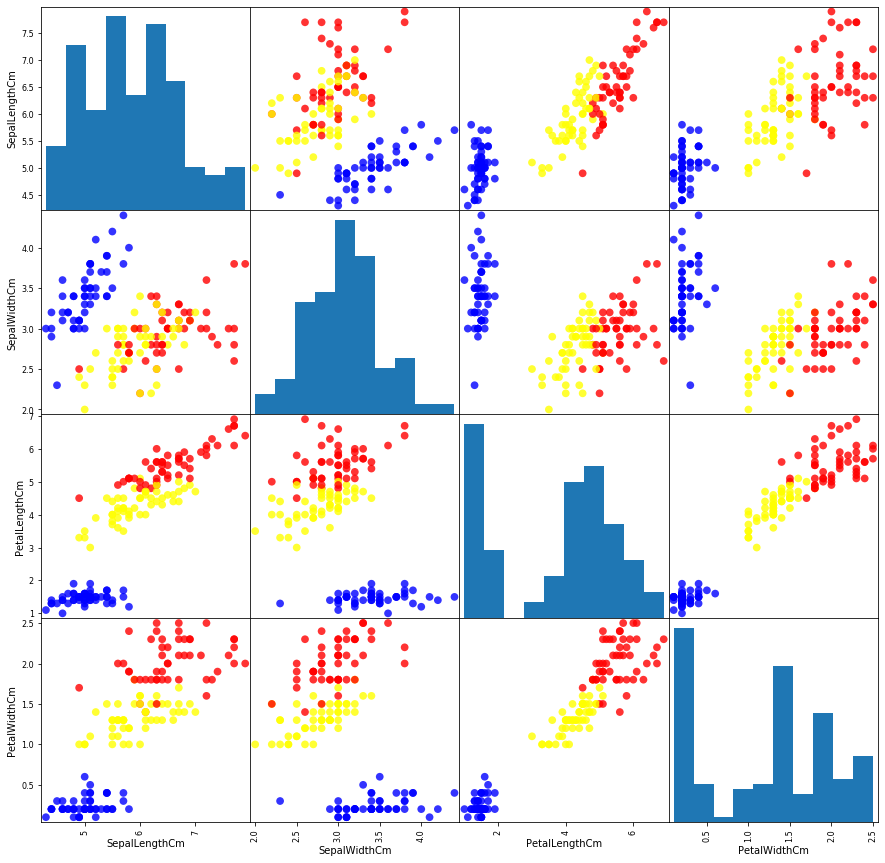

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
iris_data = pd.read_csv('iris.csv')

iris_data = iris_data.reindex(np.random.permutation(iris_data.index))
    
def assign_colors_to_iris(y_train):
    colors = []
    for row in y_train:
        assigned = "blue"
        if (row == "Iris-versicolor"):
            assigned = "yellow"
        elif(row == "Iris-virginica"):
            assigned = "red"
        colors.append(assigned)
    return colors
pd.plotting.scatter_matrix(iris_data[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]], marker='o', s=60, alpha=0.8, figsize=(15, 15), color=assign_colors_to_iris(iris_data['Species']))
plt.show()

## Analyze the Data

In [2]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 70 to 6
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [3]:
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
70,71,5.9,3.2,4.8,1.8,Iris-versicolor
55,56,5.7,2.8,4.5,1.3,Iris-versicolor
82,83,5.8,2.7,3.9,1.2,Iris-versicolor
120,121,6.9,3.2,5.7,2.3,Iris-virginica
61,62,5.9,3.0,4.2,1.5,Iris-versicolor


## Training Data

In [4]:
x_train, y_train = iris_data.drop(['Species'], axis=1)[:110], iris_data['Species'][:110]
x_test, y_test = iris_data.drop(['Species'], axis=1)[110:], iris_data['Species'][110:]
x_train.drop(["Id"], inplace=True, axis=1)

## Principal Component Analysis

[array([ 0.35395271, -0.08416199,  0.85883098,  0.36061556]), array([-0.64938112, -0.73873223,  0.1608694 ,  0.08185283])]
     SepalLengthCm  SepalWidthCm
0         1.050409      0.078267
1         0.575326      0.414449
2         0.067777      0.318677
3         2.357617     -0.385405
4         0.443758      0.104936
..             ...           ...
105       1.486108     -0.269503
106       0.399423      0.667800
107       0.642911     -0.146165
108      -3.063413      0.358332
109      -2.840229     -0.244731

[110 rows x 2 columns]


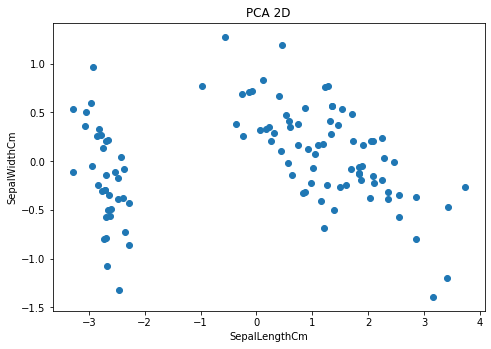

[array([ 0.35395271, -0.08416199,  0.85883098,  0.36061556]), array([-0.64938112, -0.73873223,  0.1608694 ,  0.08185283]), array([-0.5849582 ,  0.58999441,  0.06690883,  0.5524977 ])]
     SepalLengthCm  SepalWidthCm  PetalLengthCm
0         1.050409      0.078267       0.432612
1         0.575326      0.414449       0.017284
2         0.067777      0.318677      -0.195606
3         2.357617     -0.385405       0.184120
4         0.443758      0.104936       0.108718
..             ...           ...            ...
105       1.486108     -0.269503      -0.195222
106       0.399423      0.667800      -0.045664
107       0.642911     -0.146165      -0.346569
108      -3.063413      0.358332       0.191872
109      -2.840229     -0.244731       0.073145

[110 rows x 3 columns]
     SepalLengthCm  SepalWidthCm
0         1.050409      0.078267
1         0.575326      0.414449
2         0.067777      0.318677
3         2.357617     -0.385405
4         0.443758      0.104936
..             ...

KeyError: 'PetalLengthCm'

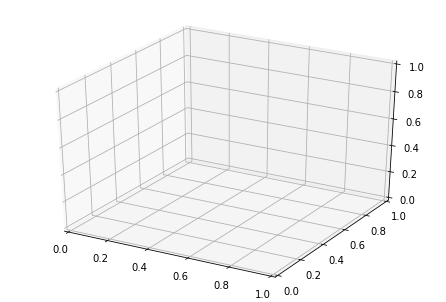

In [13]:
from mpl_toolkits.mplot3d import Axes3D

class MyPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit_transform(self, data):
        dim_mean_list = self.mean_per_dimension(data)
        centered_data = self.center_columns(data, dim_mean_list)
        cov_matrix, cov_matrix_df = self.covariance(data, dim_mean_list)
        eigenvector_list = self.eigenvector(cov_matrix, data.columns)[0:self.n_components]
        eigenvectors = [eigen[2] for eigen in eigenvector_list]
        print(eigenvectors)
        self.pca_data = pd.DataFrame(np.dot(centered_data, np.transpose(eigenvectors)), columns=[eigen[0] for eigen in eigenvector_list])
        return self.pca_data
        
    def mean_per_dimension(self, data):
        dim_mean_list = {}
        for column_name, column_data in data.iteritems():
            dim_mean_list[column_name] = np.mean(column_data)
        return dim_mean_list
        
    def covariance(self, data, dim_mean_list):
        num_features = data.shape[1]
        n_samples = data.shape[0]
        cov_matrix = [[0 for i in range(num_features)] for j in range(num_features)]
        col_index = 0
        for col_1 in data.columns:
            row_index = 0
            for col_2 in data.columns:
                cov_matrix[row_index][col_index] = 1/(n_samples-1)*np.sum((data[col_1]-dim_mean_list[col_1])*(data[col_2]-dim_mean_list[col_2]))
                row_index+=1
            col_index += 1
        cov_matrix_df =  pd.DataFrame(cov_matrix, columns=data.columns)
        cov_matrix_df.index = data.columns
        return cov_matrix, cov_matrix_df
    
    def eigenvector(self, cov_matrix, columns):
        eigenvalues, eigenvector = np.linalg.eig(cov_matrix)
        eigenvector_t = np.transpose(eigenvector)
        eigen_tuple = [(columns[i], eigenvalues[i], eigenvector_t[i]) for i in range(len(eigenvalues))]
        #sort by eigenvalue
        return sorted(eigen_tuple, key = lambda x: x[1], reverse=True)   
    
    def center_columns(self, data, mean_per_column):
        centered_df = data.copy()
        for column_name in mean_per_column:
            centered_df[column_name] = centered_df[column_name].apply(self.substract_values, value=mean_per_column[column_name])
        return centered_df.values
        
    def substract_values(self, col, value):
        return col-value
    
    def plot(self, title):
        fig=plt.figure()
        if (self.n_components == 2):
            ax=fig.add_axes([0,0,1,1])
            ax.scatter(pca_data[self.pca_data.columns[0]], pca_data[self.pca_data.columns[1]])
            ax.set_xlabel(self.pca_data.columns[0])
            ax.set_ylabel(self.pca_data.columns[1])
        elif (self.n_components == 3):
            ax = Axes3D(fig)
            print(self.pca_data)
            ax.scatter(self.pca_data[self.pca_data.columns[0]], self.pca_data[self.pca_data.columns[1]], self.pca_data[self.pca_data.columns[2]])
            ax.set_xlabel(self.pca_data.columns[0])
            ax.set_ylabel(self.pca_data.columns[1])
            ax.set_ylabel(self.pca_data.columns[2])
        ax.set_title(title)
        plt.show()
    
my_pca = MyPCA(2)
pca_data = my_pca.fit_transform(x_train)
my_pca.plot("PCA 2D")

my_pca3 = MyPCA(3)
pca_data3 = my_pca3.fit_transform(x_train)
my_pca3.plot("PCA 3D")

## Implement K-Nearest Neighbors

In [ ]:
#My own K means clustering algorithm
import random
from math import sqrt

def euclidean_distance(object1, object2):
    distance = 0.0
    for i in range(len(object1)-1):
        distance += (object1[i] - object2[i])**2
    return sqrt(distance)

def get_neighbors(train_data, test_row, k):
    distances = []
    for row in train_data.iterrows():
        train_object = row[1]
        distance = euclidean_distance(test_row, train_object)
        distances.append((distance, train_object))
    distances.sort(key=lambda tup: tup[0])
    neighbors = list()
    for i in range(k):
        neighbors.append(distances[i][1])
    return neighbors

cluster_belongings = get_neighbors(x_train, x_test.iloc[0, :], 3)